In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


## define portfolio

In [3]:
# Define the universe of stocks with the number of shares
stock_shares = {
    'AAPL': 100,  
    'MSFT': 150,  
    'GOOGL': 200,   
    'AMZN': 100,    
    'NVDA': 100,
    'ACN':200,
    'NKE':300,
    'LLY':50,
    'GS':50
}

In [4]:
long_stocks = ['AAPL', 'MSFT','NVDA','GOOGL', 'AMZN']  # Example long stocks
short_stocks = ['ACN', 'NKE','LLY','GS']  # Example short stocks

In [5]:
# Fetch historical data
all_stocks = list(stock_shares.keys())
data = yf.download(all_stocks, start='2021-01-01', end='2025-04-01',auto_adjust=True,actions=False)['Close']
sp500 = yf.download('^GSPC', start='2021-01-01', end='2025-04-01',auto_adjust=True,actions=False)['Close']


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
# Calculate notional values
notional_values = {stock: shares * data[stock].iloc[-1] for stock, shares in stock_shares.items()}

# Calculate total notional for long and short stocks
total_long_notional = sum(notional_values[stock] for stock in long_stocks)
total_short_notional = sum(notional_values[stock] for stock in short_stocks)

# Calculate weights for long and short positions
long_weights = {stock: notional_values[stock] / total_long_notional for stock in long_stocks}
short_weights = {stock: notional_values[stock] / total_short_notional for stock in short_stocks}

In [7]:
# Calculate notional values
notional_df = pd.DataFrame.from_dict({
    'Stock Code': notional_values.keys(),
    'Shares': stock_shares.values(),
    'Notional Value': [f"{value:,.2f}" for value in notional_values.values()],  # Formatting
    'Position': ['Long' if stock in long_stocks else 'Short' for stock in notional_values.keys()]
})

# Display the notional values DataFrame
print("\nNotional Values:")
print(notional_df)


Notional Values:
  Stock Code  Shares Notional Value Position
0       AAPL     100      22,213.00     Long
1       MSFT     150      56,308.50     Long
2      GOOGL     200      30,928.00     Long
3       AMZN     100      19,026.00     Long
4       NVDA     100      10,838.00     Long
5        ACN     200      62,408.00    Short
6        NKE     300      19,044.00    Short
7        LLY      50      41,295.50    Short
8         GS      50      27,314.50    Short


## portfolio performance

In [9]:
# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate notional values for long and short positions
long_notionals = np.array([notional_values[stock] for stock in long_stocks])
short_notionals = np.array([-notional_values[stock] for stock in short_stocks])  # Negative for short positions

# Calculate weighted long and short returns
long_returns = (daily_returns[long_stocks] * long_notionals / total_long_notional).sum(axis=1)
short_returns = (daily_returns[short_stocks] * short_notionals / total_short_notional).sum(axis=1)

# Combine long and short returns
portfolio_returns = long_returns + short_returns

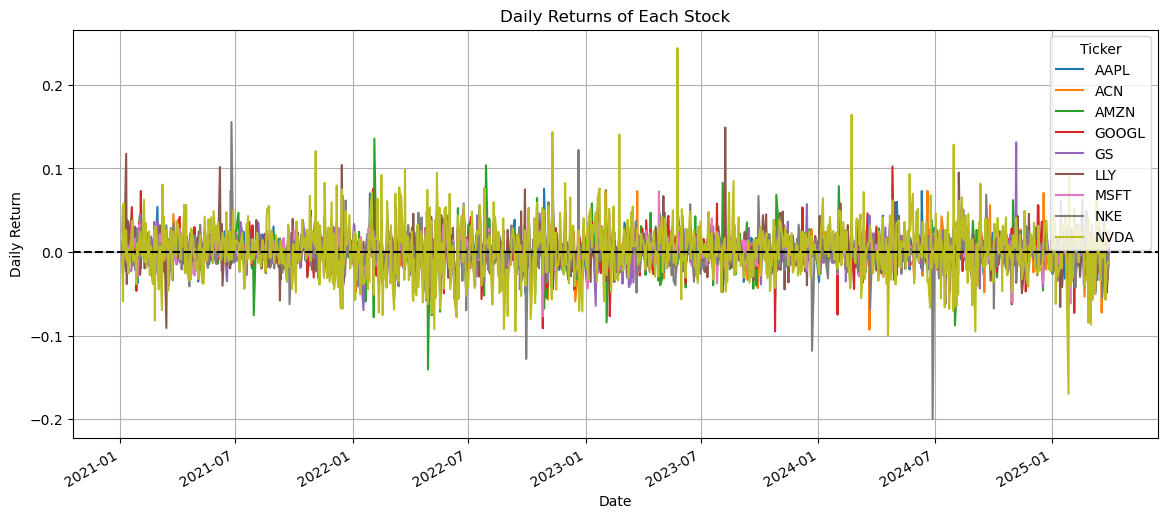

In [10]:
daily_returns.plot(title='Daily Returns of Each Stock', figsize=(14, 6))
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.axhline(0, color='black', linestyle='--')  # Optional: line at zero
plt.grid()

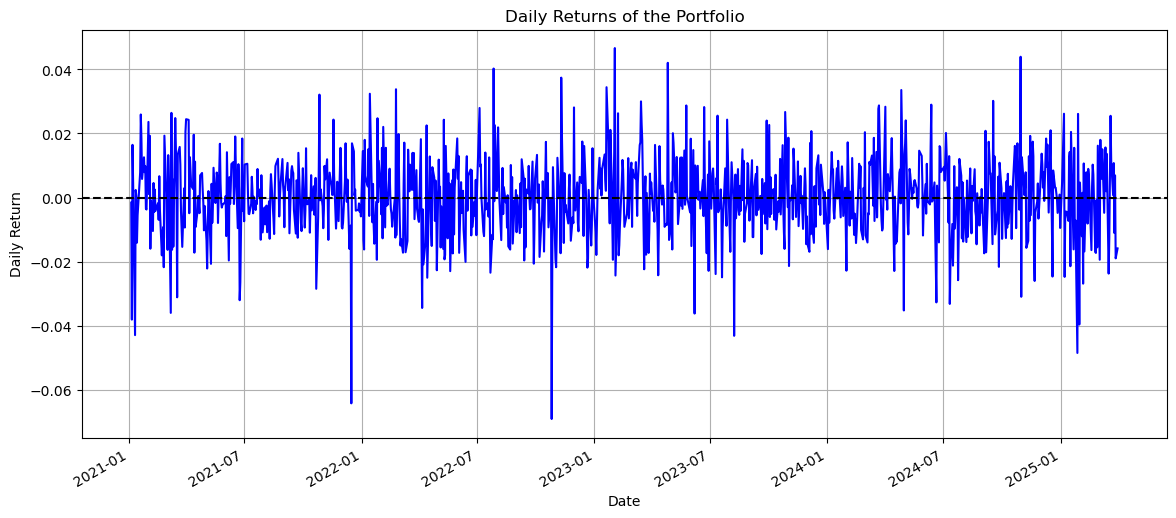

In [11]:
#in case any missing data
portfolio_returns = portfolio_returns.ffill()  # Forward fill

# Plotting daily portfolio returns
plt.figure(figsize=(14, 6))
portfolio_returns.plot(title='Daily Returns of the Portfolio', color='blue')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.axhline(0, color='black', linestyle='--')  # Line at zero for reference
plt.grid()
plt.show()

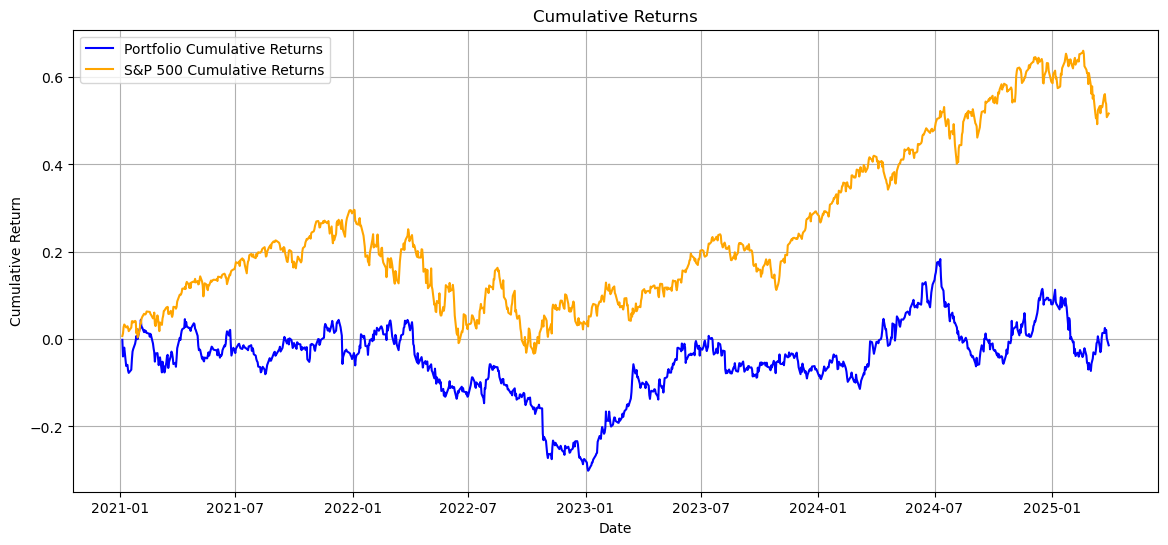

In [12]:
# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
sp500_returns = sp500.pct_change().dropna()

plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns, label='Portfolio Cumulative Returns', color='blue')
plt.plot((1 + sp500_returns).cumprod() - 1, label='S&P 500 Cumulative Returns', color='orange')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()

In [13]:
#resample for month end return
monthly_returns = portfolio_returns.resample('ME').apply(lambda x: (1 + x).prod() - 1)

In [14]:
# Convert the index to show only Year-Month
monthly_returns.index = monthly_returns.index.strftime('%Y-%m')

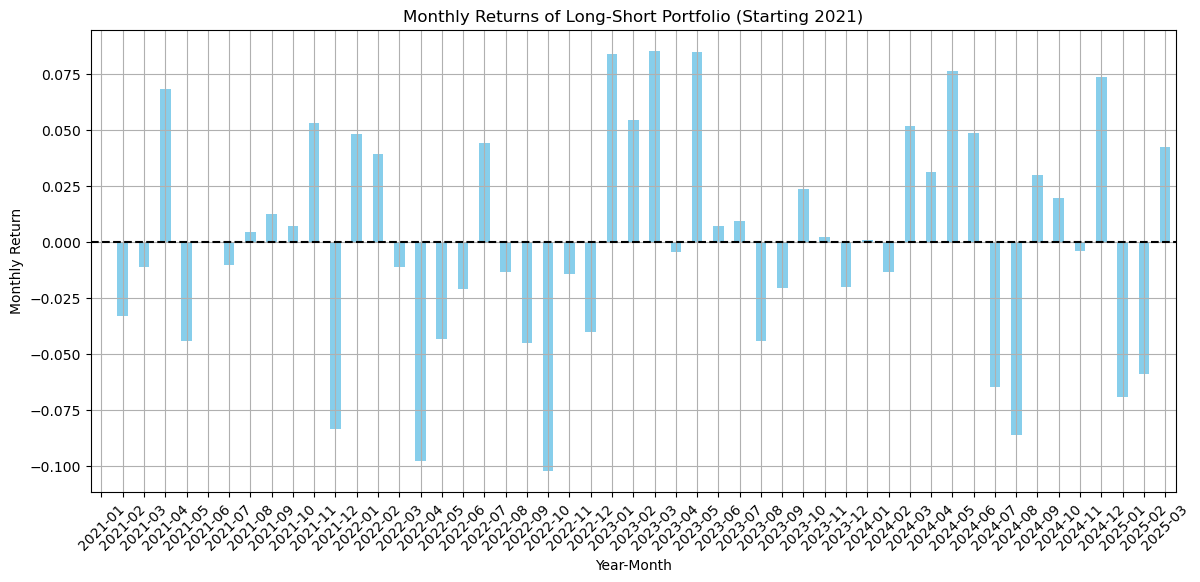

In [15]:
plt.figure(figsize=(14, 6))
monthly_returns.plot(kind='bar', title='Monthly Returns of Long-Short Portfolio (Starting 2021)', color='skyblue')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Return')
plt.axhline(0, color='black', linestyle='--')  # Optional: line at zero
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid()

In [16]:
# Calculate gross and net exposure
gross_exposure = sum([abs(stock_shares[stock] * data[stock].iloc[-1]) for stock in all_stocks])
net_exposure = sum([stock_shares[stock] * data[stock].iloc[-1] for stock in long_stocks]) - \
               sum([stock_shares[stock] * data[stock].iloc[-1] for stock in short_stocks])

In [28]:
# Create a DataFrame for exposure time series
exposure_df = pd.DataFrame(index=daily_returns.index)
exposure_df['Gross Exposure'] = (daily_returns[long_stocks] * np.array([stock_shares[stock] for stock in long_stocks])).sum(axis=1) - \
                                  (daily_returns[short_stocks] * np.array([-stock_shares[stock] for stock in short_stocks])).sum(axis=1)
exposure_df['Net Exposure'] = (daily_returns[long_stocks] * np.array([stock_shares[stock] for stock in long_stocks])).sum(axis=1) + \
                                (daily_returns[short_stocks] * np.array([-stock_shares[stock] for stock in short_stocks])).sum(axis=1)

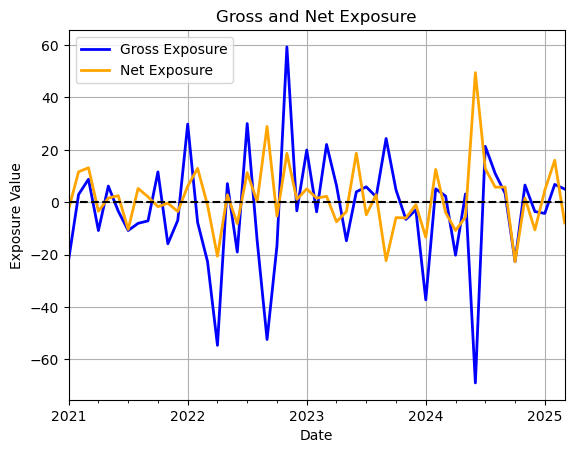

In [29]:
# Resample to get month-end values
monthly_exposure = exposure_df.resample('ME').last()

# Plot gross and net exposures
monthly_exposure[['Gross Exposure', 'Net Exposure']].plot(title='Gross and Net Exposure', color=['blue', 'orange'], linestyle='-', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Exposure Value')
plt.axhline(0, color='black', linestyle='--')  # Optional: line at zero
plt.grid()

performance metircs

In [31]:
# Performance metrics
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
annualized_return = np.mean(portfolio_returns) * 252  # Assuming 252 trading days
annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)

# Maximum Drawdown Calculation
def max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown

max_dd = max_drawdown(portfolio_returns).min()
drawdown = max_drawdown(portfolio_returns)


In [32]:
# Sharpe Ratio
risk_free_rate = 0.01  # Example risk-free rate
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Sortino Ratio
downside_returns = portfolio_returns[portfolio_returns < 0]
downside_deviation = np.std(downside_returns) * np.sqrt(252)
sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation

In [33]:
# Display the results
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Maximum Drawdown: {max_dd:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")


Annualized Return: 1.69%
Annualized Volatility: 20.09%
Maximum Drawdown: -33.18%
Sharpe Ratio: 0.03
Sortino Ratio: 0.05


## factor analysis

In [35]:
# Factor Analysis (using Fama-French 3 factors)
# Load Fama-French 3-factor data from local CSV

# link to url https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
ff_data = pd.read_csv(r'C:\Users\homel\Udemy\F-F_Research_Data_Factors.csv', skiprows=3)

In [36]:
#ff_data.head()

In [37]:
ff_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)  # Rename the first column to 'Date'

In [38]:
# Drop rows with NaN values in the 'Date' column
ff_data.dropna(subset=['Date'], inplace=True)

# Ensure the 'Date' column is treated as a string, then convert to datetime
ff_data['Date'] = ff_data['Date'].astype(str)  # Convert to string
ff_data = ff_data[ff_data['Date'].str.match(r'^\d{6}$')]  # Filter valid dates
ff_data['Date'] = pd.to_datetime(ff_data['Date'], format='%Y%m')  # Convert to datetime

In [39]:
ff_data.set_index('Date', inplace=True)

# Convert relevant columns to numeric, coercing errors to NaN
numeric_columns = ['Mkt-RF', 'SMB', 'HML', 'RF']  # Adjust this list based on your DataFrame's actual columns
ff_data[numeric_columns] = ff_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Now perform the division
ff_data = ff_data / 100  # Convert from percentage

In [40]:
# Merge with portfolio returns
combined_data = pd.concat([portfolio_returns, ff_data], axis=1).dropna()
combined_data.columns = ['Portfolio', 'Mkt-RF', 'SMB', 'HML','RF']

In [41]:
# Perform regression analysis (factor exposure)
X = combined_data[['Mkt-RF', 'SMB', 'HML']]
y = combined_data['Portfolio']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Portfolio   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.105
Date:                Fri, 11 Apr 2025   Prob (F-statistic):              0.362
Time:                        11:10:21   Log-Likelihood:                 103.18
No. Observations:                  34   AIC:                            -198.4
Df Residuals:                      30   BIC:                            -192.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.381      0.7

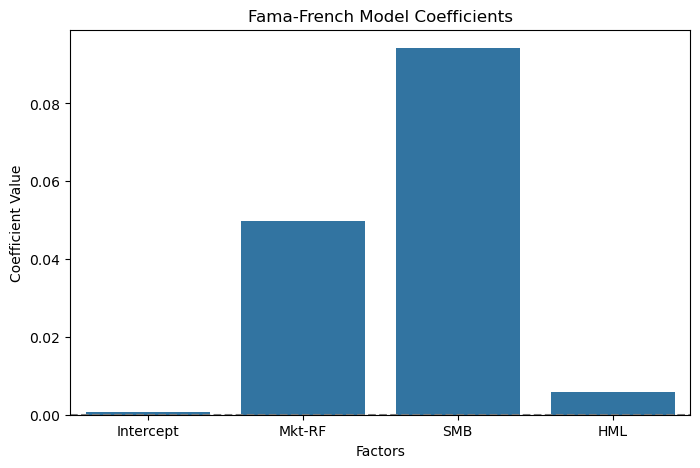

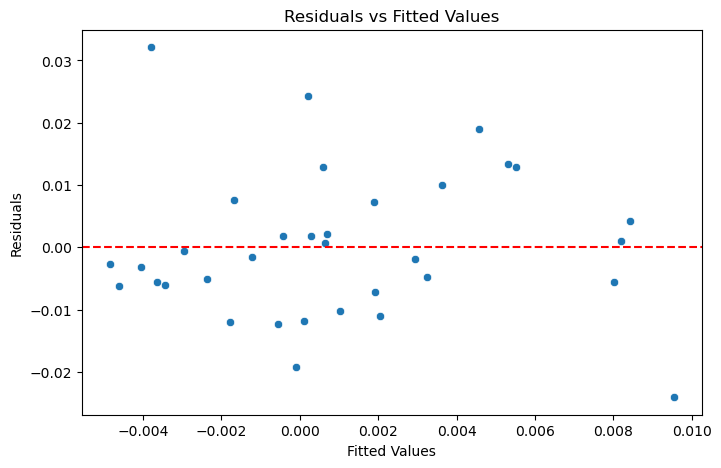

In [42]:
# Coefficients from the model
coefficients = {
    'Intercept': model.params['const'],
    'Mkt-RF': model.params['Mkt-RF'],
    'SMB': model.params['SMB'],
    'HML': model.params['HML']
}

# Create a bar plot for coefficients
plt.figure(figsize=(8, 5))
sns.barplot(x=list(coefficients.keys()), y=list(coefficients.values()))
plt.title('Fama-French Model Coefficients')
plt.xlabel('Factors')
plt.ylabel('Coefficient Value')
plt.axhline(0, color='gray', linestyle='--')
plt.show()

# Residuals
residuals = model.resid

# Create a residual plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

## portfolio risk

Portfolio Standard Deviation (Sigma): 0.0124
Value at Risk (VaR) at 95.0% confidence level: -0.0140
Conditional Value at Risk (CVaR): -0.0169


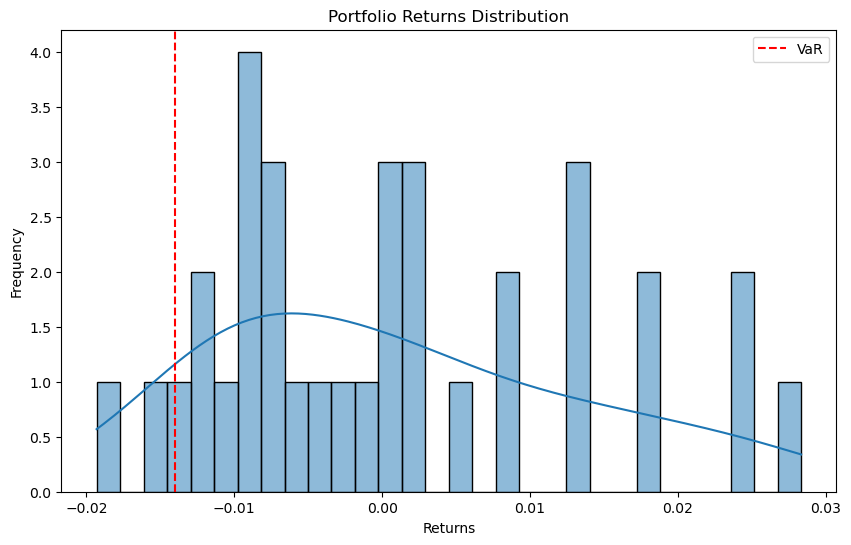

In [44]:
#Calculate the portfolio's standard deviation (sigma)
sigma = combined_data['Portfolio'].std()
print(f"Portfolio Standard Deviation (Sigma): {sigma:.4f}")

#Calculate Value at Risk (VaR)
confidence_level = 0.95
VaR = np.percentile(combined_data['Portfolio'], (1 - confidence_level) * 100)
print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {VaR:.4f}")

#Calculate Conditional VaR (CVaR)
CVaR = combined_data['Portfolio'][combined_data['Portfolio'] <= VaR].mean()
print(f"Conditional Value at Risk (CVaR): {CVaR:.4f}")

# Visualizing the portfolio returns distribution
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['Portfolio'], bins=30, kde=True)
plt.axvline(VaR, color='red', linestyle='--', label='VaR')
plt.title('Portfolio Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

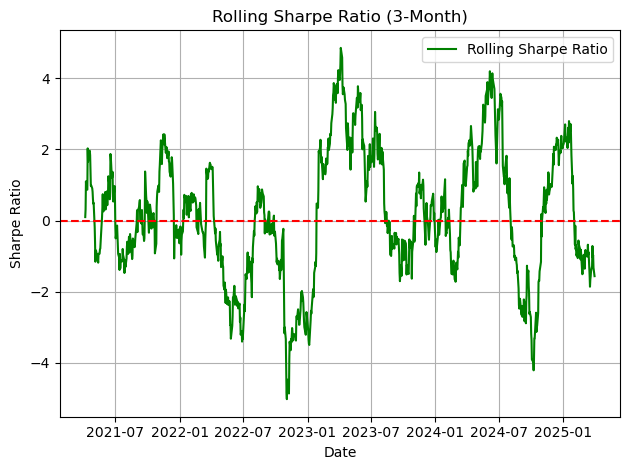

In [45]:
# Calculate rolling Sharpe Ratio
rolling_window = 63  # 63 trading days = approximately 3 months
rolling_sharpe = (portfolio_returns.rolling(rolling_window).mean() / 
                  portfolio_returns.rolling(rolling_window).std()) * np.sqrt(252)


# Rolling Sharpe Ratio
plt.plot(rolling_sharpe, label='Rolling Sharpe Ratio', color='green')
plt.title('Rolling Sharpe Ratio (3-Month)')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.axhline(0, color='red', linestyle='--')  # Optional: horizontal line at zero
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

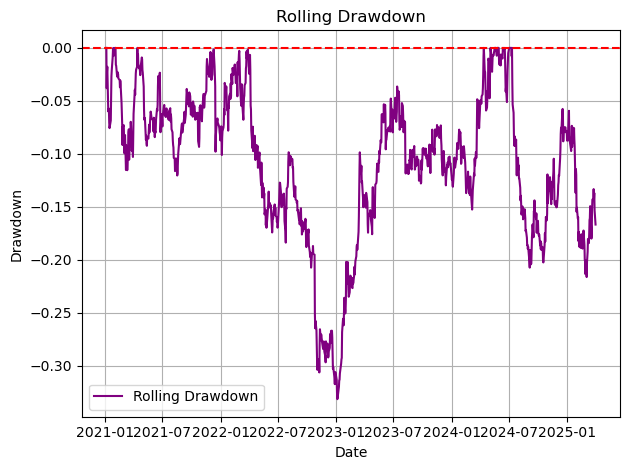

In [46]:
# Drawdown Plot
plt.plot(drawdown, label='Rolling Drawdown', color='purple')
plt.title('Rolling Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.axhline(0, color='red', linestyle='--')  # Optional: horizontal line at zero
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [47]:
# Fetch sector information using yfinance
def get_sector_info(stocks):
    sector_data = {}
    for stock in stocks:
        info = yf.Ticker(stock).info
        sector_data[stock] = info.get('sector', 'N/A')
    return sector_data

In [48]:
# Convert weights to lists
long_weights_numeric = list(long_weights.values())
short_weights_numeric = [-w for w in short_weights.values()]  # Negate short weights

# Create weights list
weights = long_weights_numeric + short_weights_numeric

In [49]:
# Fetch sector data
sector_data = get_sector_info(all_stocks)

# Create a DataFrame for sectors
sector_exposure = pd.DataFrame({
    'Stock': all_stocks,
    'Weight': weights,
})

# Map sector information to the DataFrame
sector_exposure['Sector'] = sector_exposure['Stock'].map(sector_data)

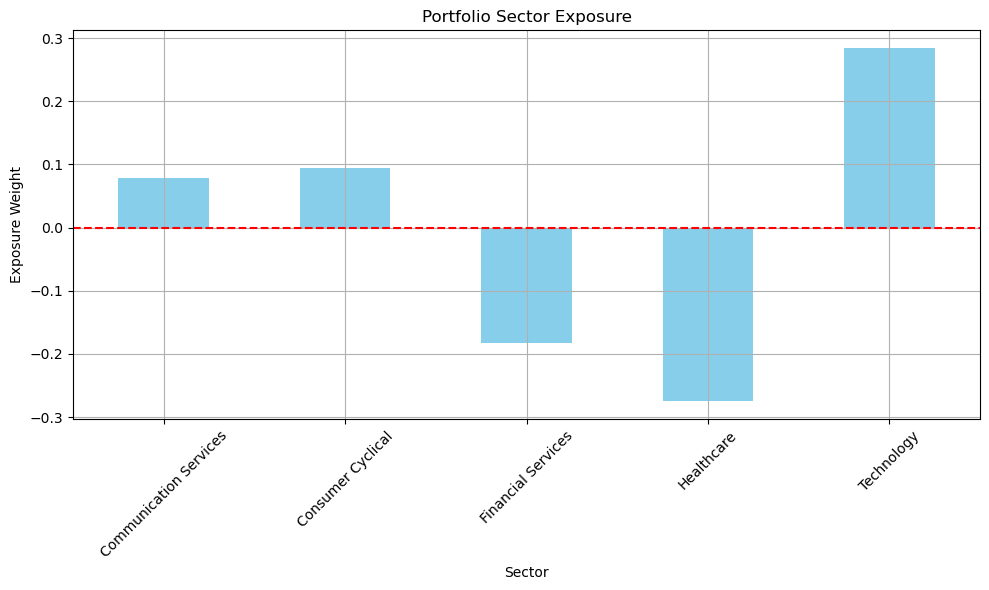

In [50]:
# Calculate sector exposure
sector_summary = sector_exposure.groupby('Sector').sum()

# Plot sector exposure
plt.figure(figsize=(10, 6))
sector_summary['Weight'].plot(kind='bar', color='skyblue')
plt.title('Portfolio Sector Exposure')
plt.xlabel('Sector')
plt.ylabel('Exposure Weight')
plt.axhline(0, color='red', linestyle='--')  # Optional: line at zero
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [51]:
# Calculate YTD returns for individual stocks
ytd_returns = {}
for stock in all_stocks:
    stock_data = yf.download(stock, start='2025-01-01', end='2025-04-01')['Close']
    ytd_return = (stock_data.iloc[-1] / stock_data.iloc[0]) - 1
    ytd_returns[stock] = ytd_return

# Create a DataFrame for YTD returns
ytd_returns_df = pd.DataFrame.from_dict(
    {key: value.values[0] for key, value in ytd_returns.items()},
    orient='index',
    columns=['YTD Return']
)

# Calculate contribution to portfolio
ytd_returns_df['Weight'] = sector_exposure.set_index('Stock')['Weight']
ytd_returns_df['Contribution'] = ytd_returns_df['YTD Return'] * ytd_returns_df['Weight']

# Ensure Contribution is numeric
ytd_returns_df['Contribution'] = pd.to_numeric(ytd_returns_df['Contribution'], errors='coerce')

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


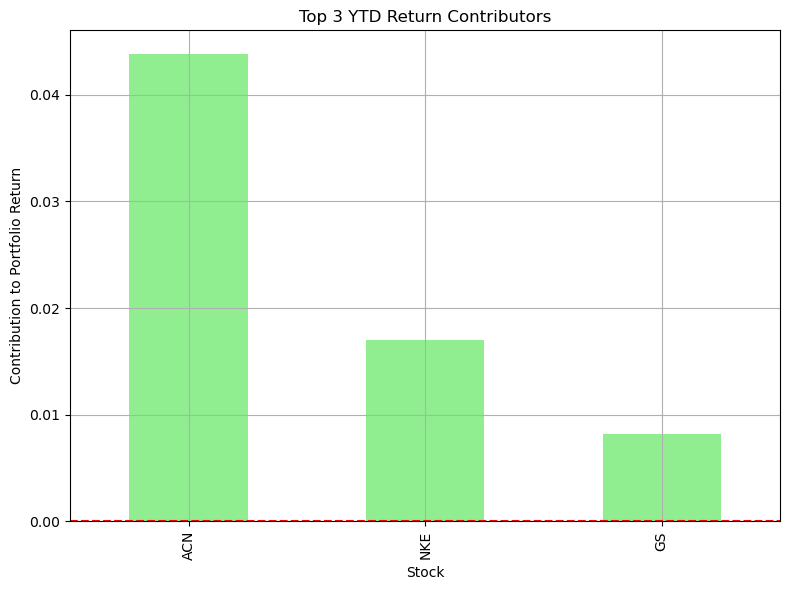

In [52]:
# Get top 3 contributors
top_contributors = ytd_returns_df.nlargest(3, 'Contribution')

# Plot top 3 YTD return contributors
plt.figure(figsize=(8, 6))
top_contributors['Contribution'].plot(kind='bar', color='lightgreen')
plt.title('Top 3 YTD Return Contributors')
plt.xlabel('Stock')
plt.ylabel('Contribution to Portfolio Return')
plt.axhline(0, color='red', linestyle='--')  # Optional: line at zero
plt.grid()
plt.tight_layout()
plt.show()

## style factor

In [54]:
style_data = pd.read_csv(r'C:\Users\homel\Udemy\12_Industry_Portfolios.csv', skiprows=11)

In [55]:
style_data.head()

,Unnamed: 0,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,192607,1.45,15.55,3.67,-1.18,8.01,3.16,0.83,7.04,0.11,1.77,-0.02,2.22
1,192608,3.97,3.68,2.42,3.47,5.14,1.97,2.17,-1.69,-0.71,4.25,4.47,4.34
2,192609,1.14,4.80,-0.07,-3.39,5.30,-0.34,2.41,2.04,0.21,0.69,-1.61,0.37
3,192610,-1.24,-8.23,-3.16,-0.78,-4.55,-5.38,-0.11,-2.63,-2.29,-0.57,-5.51,-2.73
4,192611,5.20,-0.19,3.82,0.01,5.11,4.79,1.63,3.71,6.43,5.42,2.34,2.10
